
#### ELE680 - Deep Neural Networks | Project Group 7
---
## Training RL Agents in Interactive Continuous Control Environments

---


### Tasks: Mountain Car Continuous
In this exercise, we shall solve the **[OpenAI Gym - Mountain Car Continuous](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/)** problem using **Q Learning with Experience Replay**. 

![title](https://gymnasium.farama.org/_images/mountain_car_continuous.gif)

The `Mountain Car` is a control environment defined in the OpenAI's Gym framework, initially defined by [Andrew Moore](https://www.cl.cam.ac.uk/techreports/UCAM-CL-TR-209.pdf) in his PhD work. It describes a deterministic MDP whereby a car is stochastically placed at the bottom of a sinusoidal valley. Actions are applied in one of two directions to enable the car get to a target point at the top of the valley.  The environment definition comes in two versions: one with discrete actions and the other with continuous actions. In this work, we shall only consider the continuous version (`MountainCarContinuous-v0`). 

The state (observation) space is represented by a 2D array comprised of two attributes--the _position_ and _velocity_ respectively. Actions are represented by scalars selected from the interval $[-1,1]$ and multiplied by a power of $0.0015$. For a given action, transition from current state to next is given by the following mathematical formulas:
\begin{align}
\text{velocity}_{t+1} &\coloneqq \text{velocity}_{t} + 0.0015 * \text{action} - 0.0025 * \cos(3 * \text{position}_{t}) \\
\text{position}_{t+1} &\coloneqq \text{position}_{t} + \text{velocity}_{t+1}
\end{align}
where HP represents the car's engine horsepower.

The complete details regarding the environment, state space, action space, state transition and reward mechanisms, termination conditions and other parameters are in the openAI Gym [documention](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/). The game is **considered solved when the target is hit**.

In this exercise we shall: 
- Implement an deep neural network (agent) that optimizes the Q-values required to maximize total discounted average rewards in the long term.
- Design training loop to learn from the environment using Q-learning techniques with experience replay
- Report on the training loss and cumulative total reward received over time


In [22]:
for name in dir():
    if not (name.startswith('_') or name.endswith('_')):
        del globals()[name]

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" # all | last | last_expr | none 

## 1. Environment Setup
---

In [25]:
import os
import pickle
from os.path import join
import numpy as np
from matplotlib import pyplot as plt
import random
from time import time
# import pygame
# import cv2
import gymnasium as gym

RANDOM_STATE = 1234
ENV_NAME = 'MountainCarContinuous-v0'
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
EPOCHS  = 1000
DATA_DIR = "../../Code/MountainCar/"


### 1.2 Paramaters setup

In [26]:
env = gym.wrappers.RecordVideo(
    env=gym.make(ENV_NAME, render_mode="rgb_array"), 
    video_folder=DATA_DIR, 
    name_prefix="mc_episodes", 
    episode_trigger=lambda x: x % 10 == 0,
    # episode_trigger=lambda x: False,
    # video_length=200,
    disable_logger=True
)

# Set non-positional agent class args
parameters = dict(
    epsilon=0.01, 
    max_epsilon=1,
    gamma=0.99, 
    num_actions=10,
    path=DATA_DIR,
    epsilon_decay=200,
    # recording_range=range(EPOCHS-100, EPOCHS), 
    seed=RANDOM_STATE,
)
# Set training parameters
train_parameters = dict(
    epochs=EPOCHS, 
    learningRate=0.001, 
    maxMoves=100, 
    memorySize=10000, 
    batchSize=128, 
    render=False,
    TAU=0.005
)
# Set plotting parameters
plot_parameters = dict(
    grid_on=True, 
    m_averages=EPOCHS // 10, 
    # metric=None
)

## 2. Experience Replay with secondary Target Network
---

In [27]:
from MC_Continuous.DQL_target import *


### 2.1 Create neural Agent

In [28]:
agent = target_Agent(env, **parameters)

### 2.2 Train the agent

In [29]:
start = time()
history = agent.train(**train_parameters)
print(f"Execution lapse: __{(time()-start)//60:,}__ minutes")


epoch 0: 	error = nan, cumulative reward = -3.03 (in 100 moves)
epoch 100: 	error = 2.98e-02, cumulative reward = -2.55 (in 100 moves)
epoch 200: 	error = 1.33e-02, cumulative reward = -2.95 (in 100 moves)
epoch 300: 	error = 9.02e-03, cumulative reward = -3.55 (in 100 moves)
epoch 400: 	error = 6.91e-03, cumulative reward = -2.94 (in 100 moves)
epoch 500: 	error = 5.50e-03, cumulative reward = -2.57 (in 100 moves)
epoch 600: 	error = 4.94e-03, cumulative reward = -3.08 (in 100 moves)
epoch 700: 	error = 5.02e-03, cumulative reward = -3.20 (in 100 moves)
epoch 800: 	error = 4.84e-03, cumulative reward = -2.96 (in 100 moves)
epoch 900: 	error = 4.35e-03, cumulative reward = -3.00 (in 100 moves)
Wins 0 out of 1000 plays!
Execution lapse: __23.0__ minutes


### 2.3 Plot the training losses and rewards

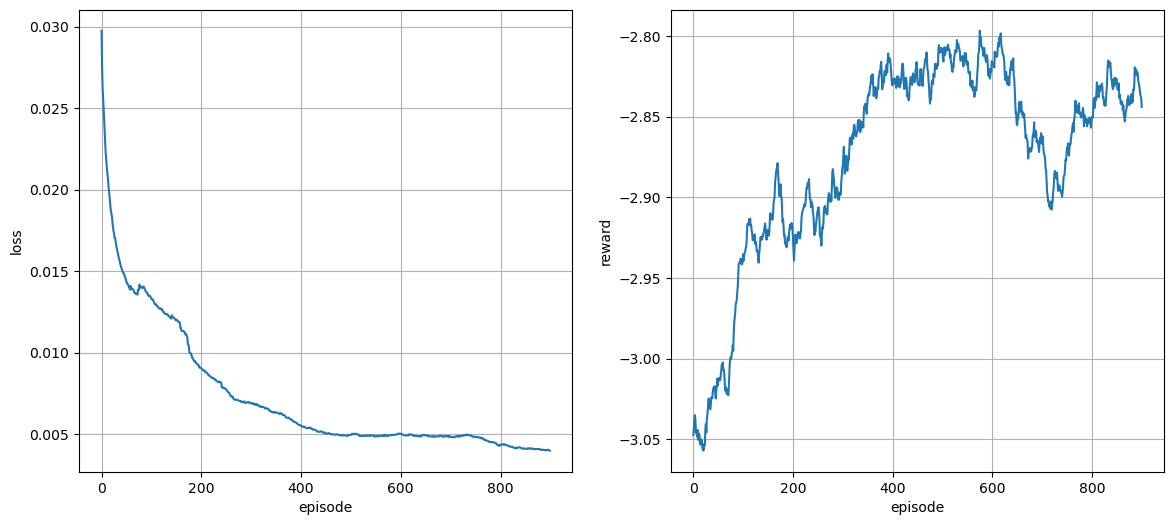

In [30]:
agent.plot_history(history, **plot_parameters)

### 2.4 Test the agent using the trained model


In [31]:
info = agent.test(numTest=10, render=True, maxMoves=100, 
                  # saved_model_path=join(parameters['path'], 'saved_model.pt')
                  ) 

Test 0: total rewards = -0.97 (in 100/100 moves)
Test 1: total rewards = -0.96 (in 100/100 moves)
Test 2: total rewards = -1.08 (in 100/100 moves)
Test 3: total rewards = -0.82 (in 100/100 moves)
Test 4: total rewards = -1.24 (in 100/100 moves)
Test 5: total rewards = -0.99 (in 100/100 moves)
Test 6: total rewards = -1.22 (in 100/100 moves)
Test 7: total rewards = -0.92 (in 100/100 moves)
Test 8: total rewards = -0.97 (in 100/100 moves)
Test 9: total rewards = -0.90 (in 100/100 moves)
  Summary
---------------
plays: 10 
wins: 0
mean (rewards): -1.0072 
std (rewards): 0.12945176707947956


In [32]:
print('actions: \t{}'.format([info[d]['actions'] for d in info]))
print('rewards: \t{}'.format([info[d]['rewards'] for d in info]))
print('terminated: \t{}'.format([info[d]['terminated'] for d in info]))

actions: 	[[0.5000000000000001, -0.29999999999999993, -0.29999999999999993, -0.29999999999999993, -0.29999999999999993, -0.29999999999999993, -0.29999999999999993, -0.29999999999999993, -0.29999999999999993, -0.29999999999999993, -0.29999999999999993, -0.29999999999999993, -0.29999999999999993, -0.29999999999999993, -0.29999999999999993, -0.29999999999999993, -0.29999999999999993, -0.29999999999999993, -0.09999999999999998, -0.09999999999999998, -0.09999999999999998, -0.09999999999999998, -0.09999999999999998, -0.29999999999999993, -0.09999999999999998, -0.29999999999999993, 0.10000000000000009, -0.29999999999999993, 0.10000000000000009, 0.10000000000000009, -0.29999999999999993, -0.09999999999999998, -0.29999999999999993, -0.7, -0.29999999999999993, 0.10000000000000009, -0.29999999999999993, -0.09999999999999998, 0.5000000000000001, -0.09999999999999998, 0.5000000000000001, -0.09999999999999998, -0.09999999999999998, -0.09999999999999998, 0.5000000000000001, -0.09999999999999998, -0.2

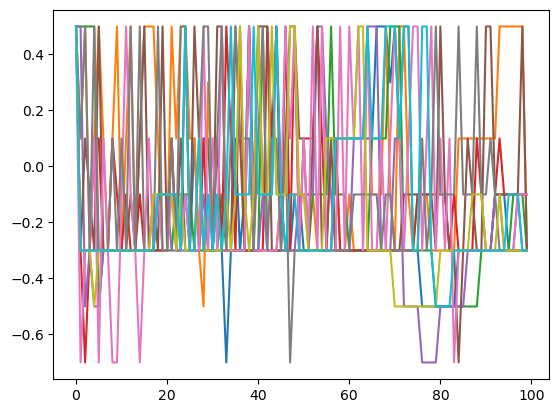

In [33]:
for d in info:
    plt.plot(info[d]['actions'])
plt.show()

In [34]:
## Save results
file1 = join(DATA_DIR, 'parameters.pickle')
with open(file1, 'wb') as fp:
    pickle.dump(parameters, fp, protocol=pickle.HIGHEST_PROTOCOL)

file1 = join(DATA_DIR, 'train_parameters.pickle')
with open(file1, 'wb') as fp:
    pickle.dump(train_parameters, fp, protocol=pickle.HIGHEST_PROTOCOL)

file1 = join(DATA_DIR, 'info.pickle')
with open(file1, 'wb') as fp:
    pickle.dump(info, fp, protocol=pickle.HIGHEST_PROTOCOL)

file1 = join(DATA_DIR, 'history.pickle')
with open(file1, 'wb') as fp:
    pickle.dump(history, fp, protocol=pickle.HIGHEST_PROTOCOL)